In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
from scipy.stats import nbinom
import scipy.stats as stats
from scipy.special import gamma
import pandas as pd
import random
from math import comb
import math
from pickle import dump
from tqdm import tqdm
from pickle import load
import timeit


In [3]:
#MLE values for the beta distribution used to approximate premise sizes
fit_alpha,fit_beta,fit_loc,fit_scale = 1.4709515345874549,3.9521542417123277,-0.024762702437304038,6.7

## Sum of degrees Boxplots

In [3]:
L = []
for i in range(1000):
    n = 100
    p = (7*n-8)/(3*n-4)
    deg_seq = nx.utils.powerlaw_sequence(n**2,p) 
    for i in range(len(deg_seq)):
        deg_seq[i] = round(deg_seq[i])
    if sum(deg_seq)%2 !=0:
        deg_seq[-1] +=1 
    L.append(sum(deg_seq))
    
total_edges_grid = 4*n**2 - 4*n
mean = (sum(L)/1000)

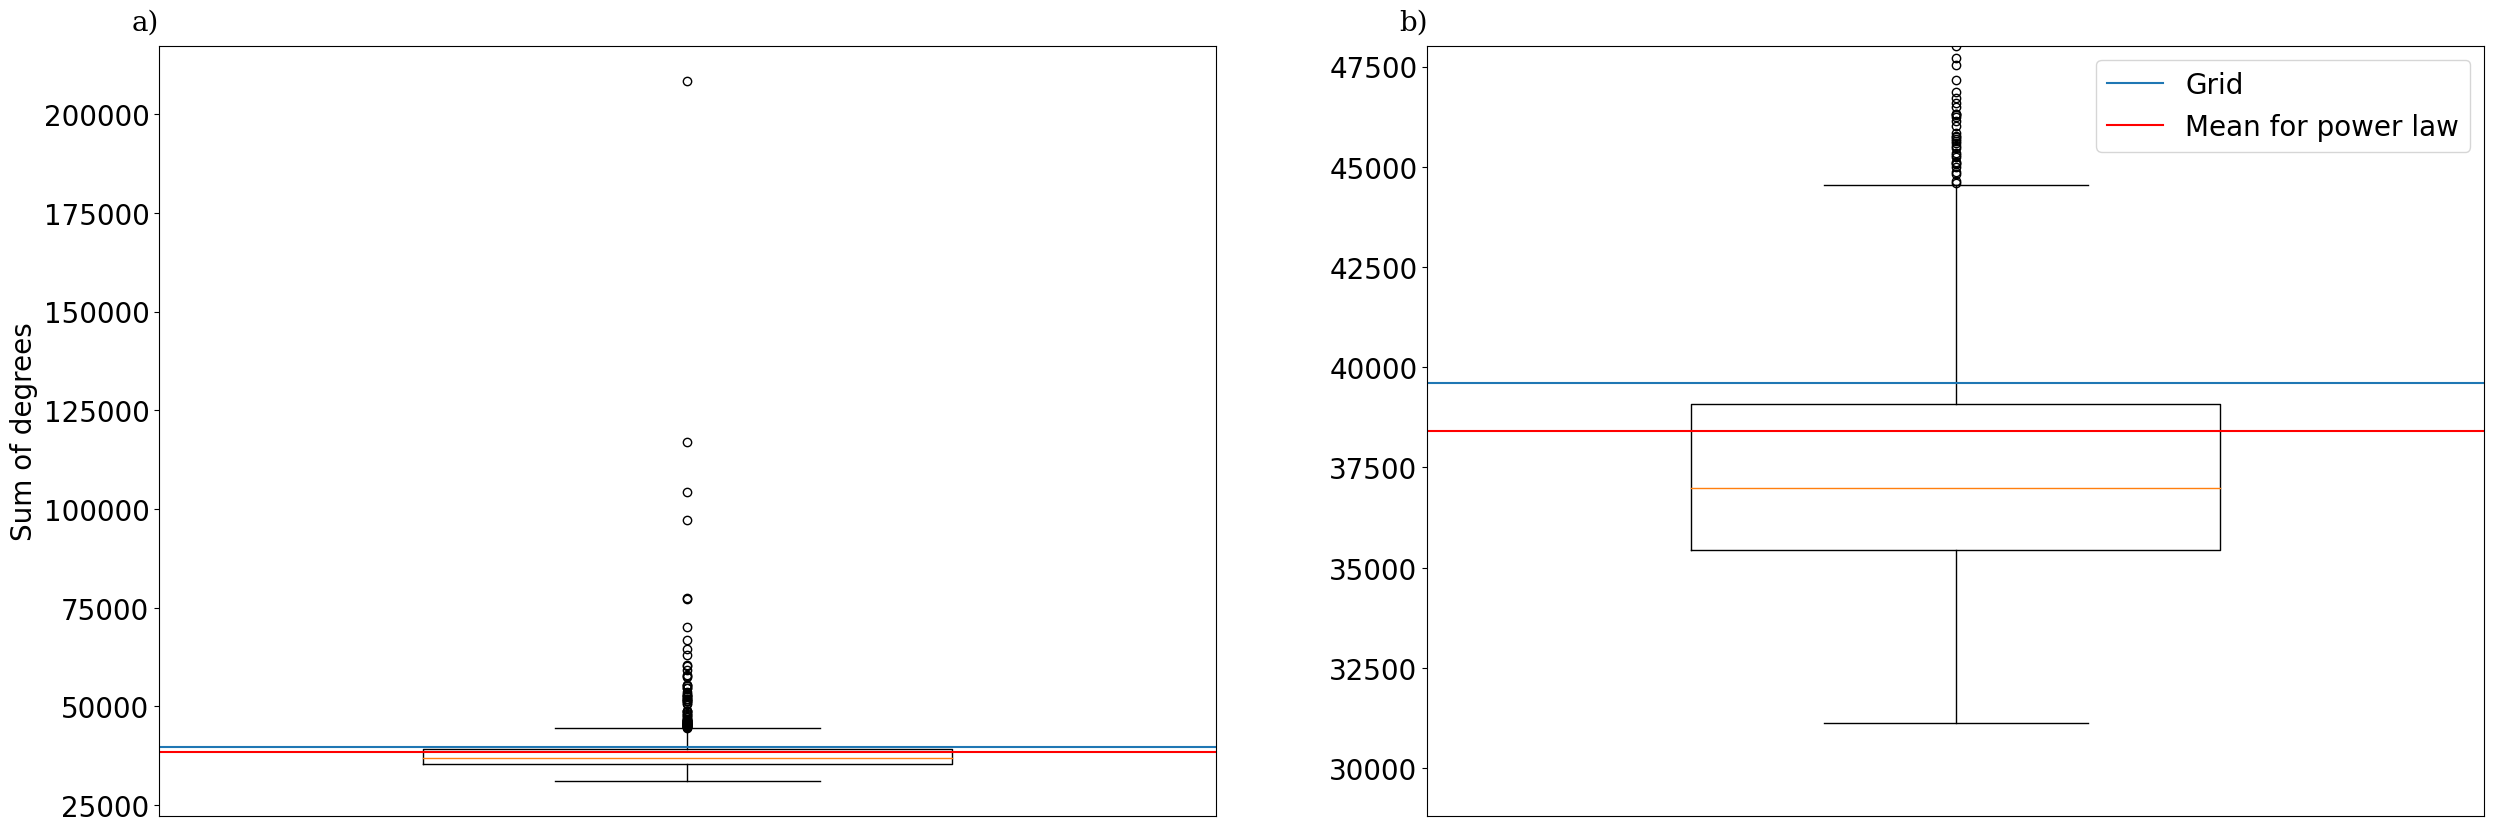

In [4]:
fig,ax = plt.subplots(1,2, figsize = (30,10))

ax[0].boxplot(L,widths = 0.5)
ax[0].axhline(4*n**2 - 4*n, label = "Sum of grid degrees")
ax[0].axhline(mean, label = "Mean sum of degrees for power law", color = "r" )
ax[0].set_ylabel("Sum of degrees")
ax[0].set_xticks([])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax[0].text(0.0, 1.0, "a)", transform=ax[0].transAxes + trans,
            fontsize=20, va='bottom', fontfamily='serif')

ax[1].boxplot(L,widths = 0.5)
ax[1].axhline(4*n**2 - 4*n, label = "Grid")
ax[1].axhline(mean, label = "Mean for power law", color = "r" )
ax[1].set_ylim([mean*0.75, mean*1.25])
ax[1].set_xticks([])

ax[1].text(0.0, 1.0, "b)", transform=ax[1].transAxes + trans,
            fontsize=20, va='bottom', fontfamily='serif')


for i in ax:
    for item in ([i.title, i.xaxis.label, i.yaxis.label] +
                 i.get_xticklabels() + i.get_yticklabels() ):
        item.set_fontsize(20)


ax[1].legend(prop = {'size': 20})
plt.savefig("images/sum_of_degrees_comparison.png")



## Old Sim code

In [5]:
def simulation(G, T, f, tau, Td,Tc, eps_wild, seasonal):
    """
    n - number of premises
    T - end time of simulation
    f - transmission force function
    d - time until detection
    mu - time until removal
    
    """
    active_cases_data = []
    new_cases_data = []
    N = len(G.nodes)
    #First Infection
    #first_infection = random.choice(list(G.nodes()))
    
    #G.nodes[first_infection]["status"] = ["I"] 
    #infected_premises = [first_infection]
    infected_premises = []
    
    t = 0
    
    while (t<T) :
        
        eps_seasonal = seasonal(t)
        
        new_infected = []
        new_recovered = []
                    
        for node in G.nodes:
            if G.nodes[node]["status"][-1] == "S":
                if check_trans(tau,node,f,G,eps_wild,eps_seasonal):
                    new_infected.append(node)

        
        
        for n in G.nodes:
            if n in new_infected:
                infected_premises.append(n)
                G.nodes[n]["status"].append("I")
        
                
            if t>=Td:
                if G.nodes[n]["status"][-Td:] == Td*["I"]:
                    G.nodes[n]["status"].append("D")
            if t>=Tc:
                if G.nodes[n]["status"][-Tc:] == Tc*["D"]:
                    G.nodes[n]["status"].append("C")
                    infected_premises.remove(n)
                    
            if len(G.nodes[n]["status"])<t+2:
                G.nodes[n]["status"].append(G.nodes[n]["status"][-1])
            
        
        t+=1
        active_cases_data.append(len(infected_premises))
        new_cases=len(new_infected)
        new_cases_data.append(new_cases)
        
        
    return new_cases_data

In [6]:
def simulation2(G, T, f, tau, Td,Tc, eps_wild, seasonal):
    """
    n - number of premises
    T - end time of simulation
    f - transmission force function
    Td - time until detection
    Tc - time until removal
    
    
    """
    active_cases_data = []
    new_cases_data = []
    N = len(G.nodes)
    #First Infection
    #first_infection = random.choice(list(G.nodes()))
    
    #G.nodes[first_infection]["status"] = ["I"] 
    #infected_premises = [first_infection]
    infected_premises = []
    
    #Generate Random number arrays
    
    RNG_eps = {node: np.random.uniform(0,1,size = T) for node in G.nodes}
    force_eps = [1e-5 for t in range(T)]
    p_eps = {node: list(map(lambda x: -expm1(-x),force_eps)) for node in G.nodes}
    check_eps_infected = {node: [p_eps[node][t]>RNG_eps[node][t] for t in range(T)] for node in G.nodes}
    
    RNG_seasonal = {node: np.random.uniform(0,1,size = T) for node in G.nodes}
    force_seasonal = [seasonal(t) for t in range(T)]
    p_seasonal = {node: list(map(lambda x: -expm1(-x),force_seasonal)) for node in G.nodes}
    check_seasonal_infected = {node: [p_seasonal[node][t]>RNG_seasonal[node][t] for t in range(T)] for node in G.nodes}
    
    RNG_N2N = {node: {node2 : np.random.uniform(0,1,size = T) for node2 in G.neighbors(node)} for node in G.nodes}
    
    chicken_numbers = pd.Series(stats.beta.rvs(fit_alpha,fit_beta, loc=fit_loc, scale=fit_scale, size = N)).map(lambda x: round(10**x))
    add_premise_attr(G,chicken_numbers)
    
    t = 0
    
    print("starts")
    
    while (t<T) :
        
        
        new_infected = []
        
        
        
        #Wild bird Infections
        for node in G.nodes:
            if G.nodes[node]["status"][-1] == "S":
                if check_seasonal_infected[node][t] or check_eps_infected[node][t]:
                    #print("WILD")
                    new_infected.append(node)
                    
                

        
        for nodeI in infected_premises:
            for nodeS in G.neighbors(nodeI):
                if G.nodes[nodeS]["status"][-1] == "S":
                    if (check_N2N_trans(tau,nodeS,nodeI,f,G)) and (nodeS not in new_infected):
                        new_infected.append(nodeS)
                        #print("N2N")
                
                
        
        
        
        for n in G.nodes:
            if n in new_infected:
                infected_premises.append(n)
                G.nodes[n]["status"].append("I")
        
                
            if t>=Td:
                if G.nodes[n]["status"][-Td:] == Td*["I"]:
                    G.nodes[n]["status"].append("D")
            if t>=Tc:
                if G.nodes[n]["status"][-Tc:] == Tc*["D"]:
                    G.nodes[n]["status"].append("C")
                    infected_premises.remove(n)
                    
            if len(G.nodes[n]["status"])<t+2:
                G.nodes[n]["status"].append(G.nodes[n]["status"][-1])
            
        
        t+=1
        active_cases_data.append(len(infected_premises))
        new_cases=len(new_infected)
        new_cases_data.append(new_cases)
    
    print("end")
    return new_cases_data

In [7]:
def check_trans(tau,node,f,G,eps_wild,eps_season):
    force = eps_wild+eps_season
    popS = G.nodes[node]["pop"]
    for node2 in G.neighbors(node):
        if G.nodes[node2]["status"][-1] == "I":
            popI = G.nodes[node2]["pop"]
            force += tau * f(popI,popS) * G.get_edge_data(node,node2)["weight"] 
    p = -expm1(-force)
    r = random.uniform(0,1)
    return r<p

In [39]:
def simulation3(G, RNG, pop, T, f, tau, Td, Tc, detected_edge_weight):
    """
    n - number of premises
    T - end time of simulation
    f - transmission force function
    Td - time until detection
    Tc - time until removal
    
    
    """
    
    active_cases_data = []
    new_cases_data = []
    wild_infections = []
    first10 = []
    
    
    N = len(G.nodes)
    #First Infection
    #first_infection = random.choice(list(G.nodes()))
    
    #G.nodes[first_infection]["status"] = ["I"] 
    #infected_premises = [first_infection]
    infected_premises = []
    
    #Generate Random number arrays
    check_eps_infected = RNG[0]
    check_seasonal_infected = RNG[1]
    
    add_premise_attr(G,pop,T)
    
   
    for n in G.nodes:
        status = G.nodes[n]["status"] 
        for s in status:
            if s != "S":
                print(s)
    
    
    
    t = 0
    wild = 0
    N2N = 0
      
    while (t<T) :
        
        new_infected = []
        
        
        
        #Wild bird Infections
        for node in G.nodes:
            if G.nodes[node]["status"][t] == "S":
                if check_seasonal_infected[node][t] or check_eps_infected[node][t]:
                    if N2N+wild<10:
                            first10.append(node)
                    wild+=1
                    new_infected.append(node)
                    wild_infections.append(node)
                    
                

        
        for nodeI in infected_premises:
            for nodeS in G.neighbors(nodeI):
                if G.nodes[nodeS]["status"][t] == "S":
                    rng = np.random.uniform(0,1)
                    if (check_N2N_trans(tau,nodeS,nodeI,f,G)>rng) and (nodeS not in new_infected):
                        new_infected.append(nodeS)
                        if N2N+wild<10:
                            first10.append(nodeS)
                        N2N+=1
                
                
        
        
        
        for n in G.nodes:
            if n in new_infected:
                infected_premises.append(n)
                G.nodes[n]["status"][t+1] = "I"
                
        
                
            
            elif G.nodes[n]["status"][t+1-Td:t+1] == Td*["I"]:
                if t>=Td:
                    G.nodes[n]["status"][t+1] = "D"
                    detection_edge_change(G,n,detected_edge_weight)
            
            elif G.nodes[n]["status"][t+1-Tc:t+1] == Tc*["D"]:
                if t>=Tc:
                    G.nodes[n]["status"][t+1] = "C"
                    infected_premises.remove(n)
                    
            else:
                G.nodes[n]["status"][t+1] = G.nodes[n]["status"][t]
            
        
        t+=1
        active_cases_data.append(len(infected_premises))
        new_cases=len(new_infected)
        new_cases_data.append(new_cases)
    
   
    
    
    return G,new_cases_data,{"Wild":wild,"N2N":N2N},wild_infections,first10

## Simulation Code

In [69]:
net_filename = "networks/grid.pkl"
T = 365
with open((net_filename), 'rb') as f1:
        G = load(f1)
no_wild = {key:[False for i in range(T)] for key in G.nodes}  

In [55]:
def simulation4(G, RNG, pop, T, f, tau, Td, Tc, Tdz, detected_edge_weight):
    """
    n - number of premises
    T - end time of simulation
    f - transmission force function
    Td - time until detection
    Tc - time until removal
    
    
    """
    
    if RNG[0] == RNG[1] == no_wild:
        return [0]*T,{"Wild":0,"N2N":0},[],[], {"S":[0]*T,"I":[0]*T,"D":[0]*T,"C":[0]*T}
    
    else:


        active_cases_data = []
        new_cases_data = []
        wild_infections = []
        first10 = []
        compartments = {"S":[],"I":[],"D":[],"C":[]}
        S = len(G.nodes())
        I = 0
        D = 0
        C = 0


        N = len(G.nodes)
        #First Infection
        #first_infection = random.choice(list(G.nodes()))

        #G.nodes[first_infection]["status"] = ["I"] 
        #infected_premises = [first_infection]
        infected_premises = []

        #Generate Random number arrays
        check_eps_infected = RNG[0]
        check_seasonal_infected = RNG[1]

        add_premise_attr(G,pop,T)


        for n in G.nodes:
            status = G.nodes[n]["status"] 
            for s in status:
                if s != "S":
                    print(s)



        t = 0
        wild = 0
        N2N = 0

        while (t<T) :

            new_infected = []



            #Wild bird Infections
            for node in G.nodes:
                if G.nodes[node]["status"][t] == "S":
                    if check_seasonal_infected[node][t] or check_eps_infected[node][t]:
                        if N2N+wild<10:
                            first10.append(node)
                        wild+=1
                     
                        new_infected.append(node)
                        wild_infections.append(node)




            for nodeI in infected_premises:
                for nodeS in G.neighbors(nodeI):
                    if G.nodes[nodeS]["status"][t] == "S":
                        rng = np.random.uniform(0,1)
                        if (check_N2N_trans(tau,nodeS,nodeI,f,G)>rng) and (nodeS not in new_infected):
                            new_infected.append(nodeS)
                            if N2N+wild<10:
                                first10.append(nodeS)
                            N2N+=1
                            





            for n in G.nodes:
                if G.nodes[n]["zone"]:

                    if n in new_infected:
                        infected_premises.append(n)
                        G.nodes[n]["status"][t+1] = "I"
                        I+=1
                        S = S-1

                    elif G.nodes[n]["status"][t+1-Tdz:t+1] == Tdz*["I"]:
                        if t>=Td:
                            G.nodes[n]["status"][t+1] = "D"
                            detection_PZ(G,n,detected_edge_weight)
                            D+=1
                            I = I-1

                    elif G.nodes[n]["status"][t+1-Tc:t+1] == Tc*["D"]:
                        if t>=Tc:
                            G.nodes[n]["status"][t+1] = "C"
                            infected_premises.remove(n)
                            C+=1
                            D = D -1

                    else:
                        G.nodes[n]["status"][t+1] = G.nodes[n]["status"][t]

                else:

                    if n in new_infected:
                        infected_premises.append(n)
                        G.nodes[n]["status"][t+1] = "I"
                        I+=1
                        S = S-1

                    elif G.nodes[n]["status"][t+1-Td:t+1] == Td*["I"]:
                        if t>=Td:
                            G.nodes[n]["status"][t+1] = "D"
                            detection_PZ(G,n,detected_edge_weight)
                            D+=1
                            I = I-1

                    elif G.nodes[n]["status"][t+1-Tc:t+1] == Tc*["D"]:
                        if t>=Tc:
                            G.nodes[n]["status"][t+1] = "C"
                            infected_premises.remove(n)
                            C+=1
                            D = D -1

                    else:
                        G.nodes[n]["status"][t+1] = G.nodes[n]["status"][t]



            t+=1
            active_cases_data.append(len(infected_premises))
            new_cases=len(new_infected)
            new_cases_data.append(new_cases)
            compartments["S"].append(S)
            compartments["I"].append(I)
            compartments["D"].append(D)
            compartments["C"].append(C)
            





        return new_cases_data,{"Wild":wild,"N2N":N2N},wild_infections,first10,compartments

In [56]:
def add_premise_attr(G,pop,T):
    
    node_attr = {}
    i=0
    for node in G.nodes():
        node_attr[node] = {"pop": pop[i],
                          "status":["S" for i in range(T+1)],
                          "zone" : False}
        i+=1
        
    for e in G.edges:
        G.get_edge_data(e[1],e[0])["weight"] = 1
    nx.set_node_attributes(G,node_attr)

In [57]:
def check_N2N_trans(tau,nodeS,nodeI,f,G):
    popS = G.nodes[nodeS]["pop"]
    popI = G.nodes[nodeI]["pop"]
    force = tau * f(popI,popS) * G.get_edge_data(nodeI,nodeS)["weight"] 
    p = -expm1(-force)
    return p

In [58]:
def detection_PZ(G,node,new_weight):
    G.nodes[node]["zone"] = True
    for e in G.edges(node):
        G.get_edge_data(e[1],e[0])["weight"] = new_weight   
            
            
    for n1 in G.neighbors(node):
        G.nodes[n1]["zone"] = True
        for e in G.edges(n1):
            G.get_edge_data(e[1],e[0])["weight"] = new_weight   

In [59]:
def detection_edge_change(G,node,new_weight):
    for e in G.edges(node):
        G.get_edge_data(e[1],e[0])["weight"] = new_weight   

In [60]:
def reset_node_status(G):
    for n in G.nodes():
        nx.set_node_attributes(G,{n:{"status":["S"]}})

In [61]:
def expm1(x):
    if abs(x) < 1e-5:
        return x + 0.5*x*x
    else:
        return math.exp(x) - 1.0

In [62]:
def indicator_seasonal(t,eps_seasonal):
    if t<=150:
        return eps_seasonal
    else:
        return 0

## Simulation runs

In [63]:
def generate_RNG(eps_wild,eps_seasonal,G,T):
    RNG_eps = {node: np.random.uniform(0,1,size = T) for node in G.nodes}
    force_eps = [eps_wild for t in range(T)]
    p_eps = {node: list(map(lambda x: -expm1(-x),force_eps)) for node in G.nodes}
    check_eps_infected = {node: [p_eps[node][t]>RNG_eps[node][t] for t in range(T)] for node in G.nodes}

    RNG_seasonal = {node: np.random.uniform(0,1,size = T) for node in G.nodes}
    force_seasonal = [indicator_seasonal(t,eps_seasonal) for t in range(T)]
    p_seasonal = {node: list(map(lambda x: -expm1(-x),force_seasonal)) for node in G.nodes}
    check_seasonal_infected = {node: [p_seasonal[node][t]>RNG_seasonal[node][t] for t in range(T)] for node in G.nodes}

    
    RNG = [check_eps_infected, check_seasonal_infected]
    
    return RNG

### Fitting

In [98]:
f = lambda I,S: (I**0.5)*(S**0.5)

    
T = 365
Td = 4
Tdz = 3
Tc = 3

In [124]:
def fit_tau(theta,start_low,start_high,tol,grid_type,outbreak_size):
    eps_wild = theta["eps_wild"]
    eps_seasonal = theta["eps_seasonal"]
    tau_low = start_low
    tau_high = start_high
    mean_outbreak_size = 123876213
    
    while abs(mean_outbreak_size-outbreak_size)>tol:
        tau = 0.5*(tau_low+tau_high)
        S = 0
        n=0
        for g in range(1,11,1):
            if grid_type == "grid":
                filename = "networks/grid.pkl"
            else:
                filename = "networks/grid_r_D=" +str(grid_type)+"_"+ str(g).rjust(3,"0")+".pkl"
            
            with open((filename), "rb") as file:
                G = load(file)
            
            for i in range(20):
                RNG = generate_RNG(eps_wild,eps_seasonal,G,T)
                y = simulation4(G,RNG,pop, T, f, tau, Td,Tc,Tdz,0.1)
                if y[1]["N2N"] > 0:
                    n+=1
                    S+= y[1]["Wild"] + y[1]["N2N"]

        print("tau: ", tau, "eps_wild: ", eps_wild, "eps_seasonal", eps_seasonal)
        print(S/n)  


        mean_outbreak_size = S/n
        if mean_outbreak_size >= outbreak_size:
            tau_high = tau
        if mean_outbreak_size < outbreak_size:
            tau_low = tau
    
    theta["tau"] = tau
    return theta
    

In [126]:
theta_grid_pre2021 = {"tau": 9e-4, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_grid_pre2021 = fit_tau(theta_grid_pre2021,10.5e-4,11.5e-4,0.5,"grid",16)

tau:  0.0010999999999999998 eps_wild:  0 eps_seasonal 3.326e-06
15.253164556962025
tau:  0.001125 eps_wild:  0 eps_seasonal 3.326e-06
19.517857142857142
tau:  0.0011124999999999998 eps_wild:  0 eps_seasonal 3.326e-06
16.72222222222222
tau:  0.0011062499999999998 eps_wild:  0 eps_seasonal 3.326e-06
17.606060606060606
tau:  0.001103125 eps_wild:  0 eps_seasonal 3.326e-06
19.403508771929825
tau:  0.0011015625 eps_wild:  0 eps_seasonal 3.326e-06
18.43103448275862
tau:  0.0011007812499999998 eps_wild:  0 eps_seasonal 3.326e-06
15.909090909090908


In [127]:
theta_grid_pre2021

{'tau': 0.0011007812499999998, 'eps_wild': 0, 'eps_seasonal': 3.326e-06}

In [135]:
theta_D1_pre2021 = {"tau": 7.1e-4, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D1_pre2021 = fit_tau(theta_D1_pre2021,7e-4,9e-4,0.75,1,16)

tau:  0.0007999999999999999 eps_wild:  0 eps_seasonal 3.326e-06
15.456521739130435


In [153]:
theta_D1_pre2021

{'tau': 0.0007999999999999999, 'eps_wild': 0, 'eps_seasonal': 3.326e-06}

In [136]:
theta_D15_pre2021 = {"tau": 4.9e-4, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D15_pre2021 = fit_tau(theta_D15_pre2021,4e-4,6e-4,0.75,1.5,16)

tau:  0.0005 eps_wild:  0 eps_seasonal 3.326e-06
13.065217391304348
tau:  0.0005499999999999999 eps_wild:  0 eps_seasonal 3.326e-06
16.471698113207548


In [137]:
theta_D15_pre2021

{'tau': 0.0005499999999999999, 'eps_wild': 0, 'eps_seasonal': 3.326e-06}

In [143]:
theta_D2_pre2021 = {"tau": 5e-4, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D2_pre2021 = fit_tau(theta_D2_pre2021,4e-4,6e-4,0.75,2,16)

tau:  0.0005 eps_wild:  0 eps_seasonal 3.326e-06
13.928571428571429
tau:  0.0005499999999999999 eps_wild:  0 eps_seasonal 3.326e-06
21.18032786885246
tau:  0.000525 eps_wild:  0 eps_seasonal 3.326e-06
13.283018867924529
tau:  0.0005375 eps_wild:  0 eps_seasonal 3.326e-06
15.943396226415095


In [144]:
theta_D2_pre2021

{'tau': 0.0005375, 'eps_wild': 0, 'eps_seasonal': 3.326e-06}

In [141]:
theta_D3_pre2021 = {"tau": 5e-4, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D3_pre2021 = fit_tau(theta_D2_pre2021,2e-4,4e-4,0.75,3,16)

tau:  0.00030000000000000003 eps_wild:  0 eps_seasonal 3.326e-06
13.975
tau:  0.00035000000000000005 eps_wild:  0 eps_seasonal 3.326e-06
21.17142857142857
tau:  0.00032500000000000004 eps_wild:  0 eps_seasonal 3.326e-06
21.423076923076923
tau:  0.00031250000000000006 eps_wild:  0 eps_seasonal 3.326e-06
14.282051282051283
tau:  0.00031875 eps_wild:  0 eps_seasonal 3.326e-06
13.605263157894736
tau:  0.000321875 eps_wild:  0 eps_seasonal 3.326e-06
16.192307692307693


In [142]:
theta_D3_pre2021

{'tau': 0.000321875, 'eps_wild': 0, 'eps_seasonal': 3.326e-06}

In [177]:
def fit_eps(theta,start_low,start_high,tol,grid_type,outbreak_size):
    tau = theta["tau"]
    eps_low = start_low
    eps_high = start_high
    mean_outbreak_size = 123876213
    
    while abs(mean_outbreak_size-outbreak_size)>tol:
        eps_seasonal = 0.5*(eps_low+eps_high)
        eps_wild = (1.348)*eps_seasonal
        S = 0
        n=0
        for g in range(1,11,1):
            if grid_type == "grid":
                filename = "networks/grid.pkl"
            else:
                filename = "networks/grid_r_D=" +str(grid_type)+"_"+ str(g).rjust(3,"0")+".pkl"
            
            with open((filename), "rb") as file:
                G = load(file)
            
            for i in range(20):
                RNG = generate_RNG(eps_wild,eps_seasonal,G,T)
                y = simulation4(G,RNG,pop, T, f, tau, Td,Tc,Tdz,0.1)
                if y[1]["N2N"] > 0:
                    n+=1
                    S+= y[1]["Wild"] + y[1]["N2N"]

        print("tau: ", tau, "eps_wild: ", eps_wild, "eps_seasonal", eps_seasonal)
        print(S/n)  


        mean_outbreak_size = S/n
        if mean_outbreak_size >= outbreak_size:
            eps_high = eps_seasonal
        if mean_outbreak_size < outbreak_size:
            eps_low = eps_seasonal
    
    theta["eps_seasonal"] = eps_seasonal
    theta["eps_wild"] = eps_wild
    return theta
    

In [ ]:
theta_grid_post2021 = {"tau":  0.00110078125, "eps_wild": 4e-6, "eps_seasonal" : 3.5e-6}
theta_grid_post2021 = fit_eps(theta_grid_post2021,3e-5,4e-5,2,"grid",160)

tau:  0.00110078125 eps_wild:  4.7180000000000006e-05 eps_seasonal 3.5000000000000004e-05
153.52
tau:  0.00110078125 eps_wild:  5.055000000000001e-05 eps_seasonal 3.7500000000000003e-05
163.64


In [174]:
theta_grid_post2021

{'tau': 0.00110078125,
 'eps_wild': 4.8035714285714286e-05,
 'eps_seasonal': 4.203125e-05}

In [175]:
theta_D1_post2021 = {"tau": 0.0008, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D1_post2021 = fit_eps(theta_D1_post2021,5.25e-5,5.75e-5,1,1,160)

tau:  0.0008 eps_wild:  6.285714285714286e-05 eps_seasonal 5.5e-05
165.225
tau:  0.0008 eps_wild:  6.142857142857143e-05 eps_seasonal 5.3750000000000005e-05
156.68
tau:  0.0008 eps_wild:  6.214285714285714e-05 eps_seasonal 5.437500000000001e-05
159.205


In [176]:
theta_D1_post2021

{'tau': 0.0008,
 'eps_wild': 6.214285714285714e-05,
 'eps_seasonal': 5.437500000000001e-05}

In [159]:
theta_D15_post2021 = {"tau": 0.00055, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D15_post2021 = fit_eps(theta_D15_post2021,6.3e-5,6.5e-5,1,1.5,160)

tau:  0.00055 eps_wild:  7.314285714285714e-05 eps_seasonal 6.4e-05
159.465


In [161]:
theta_D15_post2021

{'tau': 0.00055, 'eps_wild': 7.314285714285714e-05, 'eps_seasonal': 6.4e-05}

In [164]:
theta_D2_post2021 = {"tau": 0.00045, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D2_post2021 = fit_eps(theta_D2_post2021,7e-5,9e-5,1,2,160)

tau:  0.00045 eps_wild:  9.142857142857142e-05 eps_seasonal 7.999999999999999e-05
161.125
tau:  0.00045 eps_wild:  8.57142857142857e-05 eps_seasonal 7.5e-05
157.12
tau:  0.00045 eps_wild:  8.857142857142855e-05 eps_seasonal 7.749999999999999e-05
158.98
tau:  0.00045 eps_wild:  8.999999999999998e-05 eps_seasonal 7.874999999999999e-05
159.07


In [165]:
theta_D2_post2021

{'tau': 0.00045,
 'eps_wild': 8.999999999999998e-05,
 'eps_seasonal': 7.874999999999999e-05}

In [167]:
theta_D3_post2021 = {"tau": 0.000325, "eps_wild": 0, "eps_seasonal" : 3.326e-6}
theta_D3_post2021 = fit_eps(theta_D3_post2021,0.9e-4,1e-4,1,3,160)

tau:  0.000325 eps_wild:  0.00010857142857142858 eps_seasonal 9.5e-05
154.72
tau:  0.000325 eps_wild:  0.00011142857142857143 eps_seasonal 9.750000000000001e-05
160.505


In [168]:
theta_D3_post2021 

{'tau': 0.000325,
 'eps_wild': 0.00011142857142857143,
 'eps_seasonal': 9.750000000000001e-05}

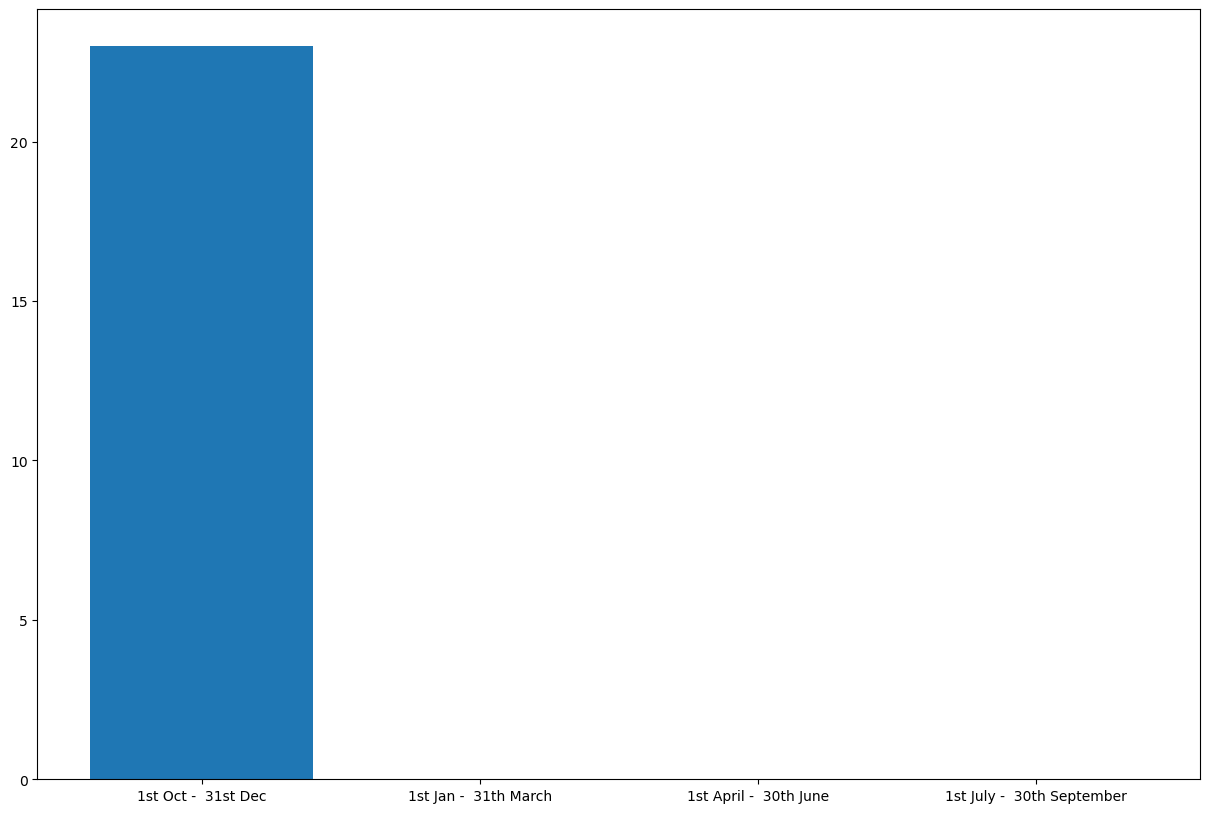

In [152]:
eps_wild = theta_grid_post2021["eps_wild"]
eps_seasonal = theta_grid_post2021["eps_seasonal"]
tau = theta_grid_post2021["tau"] 
RNG = generate_RNG(eps_wild,eps_seasonal,G,T)
y = simulation4(G,RNG,pop, T, f, tau, Td,Tc,Tdz,0.1)[1]
    

blocks = [0,92,182,273,365]
data = [0,0,0,0]
for i in range(4):
    start = blocks[i]
    end = blocks[i+1]
    for j in range(start,end):
        data[i]+=y[j]

fig, ax = plt.subplots(1,1,figsize = (15,10))
Xaxis = [1,2,3,4]
ax.bar([1,2,3,4],data)
ax.set_xticks([1,2,3,4], ['1st Oct -  31st Dec','1st Jan -  31th March','1st April -  30th June', '1st July -  30th September'])

## Generate Simulations